# Creating datasets and adding files
In this example we create a qdrive dataset and add: some measurement data and a setting file.
Then we load this dataset, perform a fitting analysis, and add to the same dataset: the fitting analisys data, the fit parameters, the fit image.

You can use the dataqruiser app to view the data.

Before running this notebook make sure:
- you installed the dataqruiser App and qdrive python package (https://docs.dataqruiser.com/installation.html#)
- you connnect this notebook to the python kernel where you installed qdrive

You can download this jupyter notebook and more examples from [here](https://github.com/qEncoder/dataQruiser/tree/main/examples).

## Log in
You'll have to do this only once. Run the command below, or login from the qdrive sync GUI, running 
`python -c "import qdrive; qdrive.launch_GUI()"` on a terminal or anaconda prompt.

In [13]:
import qdrive
# qdrive.authenticate_with_console()

## Creating a dataset
Here we create a qdrive dataset which is automatically syncronized to the server and it will appear in the dataQruiser app

In [14]:
from qdrive import dataset

dsq = dataset.create('Test ds from python', scope_name=None, description='test dataset') #if socpe name is not set it will use the default scope set in sync GUI
dsq 

Contents of dataset :: Test ds from python

uuid :: 7401c239-02b4-4a15-8d99-afa40ac120bb
Description :: test dataset
Scope :: test scope QH
Ranking :: 0
Files :: 
No files present in the current dataset.

## Creating mock data

In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# measured mock data
x1_data = np.linspace(-3, 3, 100)
x2_data = np.linspace(-1, 1, 100)      
m1_data = np.sin(4*x1_data) + 0.1 * np.random.normal(size=len(x1_data))
X1, X2 = np.meshgrid(x1_data, x2_data)
m2_data = np.sin(X1) * np.sin(X2) + 0.1 * np.random.normal(size=X1.shape)

# Put data in a xarray with labels and units.
xr_ds = xr.Dataset(
    {
        "m1": (["x1"], m1_data, {"units": "m1_units"}),
        "m2": (["x1", "x2"], m2_data, {"units": "m2_units"}),
    },
    coords={
        "x1": ("x1", x1_data, {"units": "x1_units"}),
        "x2": ("x2", x2_data, {"units": "x2_units"}),
    }
)

# Add some HDF5 attributes to the xarray (they will be stored in the HDF5 file)
xr_ds.attrs = {'m1':1, 'm2':2, 'mm':{'mm1':[1,2,3], 'mm2':[1,2,3]}}

# xr_ds

## Adding data to qdrive dataset
Here we add several files to the qdrive dataset. The dataset is automatically syncronized to the server and the added files will appear in the dataQruiser app.

In [16]:
# Add the mock data from the xarray (as HDF5 NETCDF4 file)
dsq['measurement.hdf5'] = xr_ds

# Add a dictionary with the measurement settings (as JSON file)
dsq['settings.json'] = {'setting_1':100, 'setting_2':[1,2,3]}

# Add a README file
dsq['README.txt'] = 'This is a README file'

# Specify dataset description, tags, attributes and ranking
dsq.description = 'My dataset description'
dsq.tags.append('tuning')
dsq.attributes = {
    'set_up': 'Fridge B256',
    'sample_id': 'Q7-R3'
}
dsq.ranking = 1  # 1 = like, 0 = neutral, -1 = dislike/hidden

## Accessing the data
To access a dataset you need its uuid. You can copy the uuid or the entire python import statement for a certain dataset from the dataQruiser app, clicking the button `Copy..` > `copy python import`.

In [17]:
# Replace this with the import statement copied from DataQrusier app
uuid = dsq.uuid 

from qdrive import dataset
dsq = dataset(uuid) 
dsx = dsq['measurement.hdf5'].xarray 


In [18]:
# Inspect the qdrive dataset
dsq

Contents of dataset :: Test ds from python

uuid :: 7401c239-02b4-4a15-8d99-afa40ac120bb
Description :: My dataset description
Scope :: test scope QH
Ranking :: 1
Data Indentifiers :: 
	set_up : Fridge B256
	sample_id : Q7-R3
Files :: 
name         filename          type                  selected version number (version_id)      Maximal version number  Starred    Hidden
-----------  ----------------  --------------------  --------------------------------------  ------------------------  ---------  --------
measurement  measurement.hdf5  FileType.HDF5_NETCDF  0 (1756658157017)                                              0  No         No
settings     settings.json     FileType.JSON         0 (1756658157035)                                              0  No         No
README       README.txt        FileType.UNKNOWN      0 (1756658157042)                                              0  No         No

In [19]:
# Inspect the xarray dataset containing the measurement data
dsx

<xarray.Dataset> Size: 82kB
Dimensions:  (x1: 100, x2: 100)
Coordinates:
  * x1       (x1) float64 800B -3.0 -2.939 -2.879 -2.818 ... 2.879 2.939 3.0
  * x2       (x2) float64 800B -1.0 -0.9798 -0.9596 ... 0.9596 0.9798 1.0
Data variables:
    m1       (x1) float64 800B ...
    m2       (x1, x2) float64 80kB ...
Attributes:
    m1:       1
    m2:       2
    mm:       {'mm1': [1, 2, 3], 'mm2': [1, 2, 3]}

## Fitting and generating a png plot
In this section we fit the measurement data, and add the fitting data, the fit parameters, the fit.png image and the analysis script to the qdrive dataset.

In [20]:
# !pip install scipy

In [21]:
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

# Fit functions
def fit_func_m1(x, a, b):
    return a * np.sin(b * x)

def fit_func_m2(params, x1, x2):
    a = params[0]
    return a * np.sin(x1) * np.sin(x2)

# Fit m1_data
params_m1, _ = curve_fit(fit_func_m1, x1_data, m1_data, p0=[1, 4])
m1_fitted = fit_func_m1(x1_data, *params_m1)

# Fit m2_data
def objective_func_m2(params, x1, x2, data):
    return (fit_func_m2(params, x1, x2) - data).ravel()
initial_guess_m2 = [1]
result_m2 = least_squares(objective_func_m2, initial_guess_m2, args=(X1, X2, m2_data))
params_m2 = result_m2.x
m2_fitted = fit_func_m2(params_m2, X1, X2)

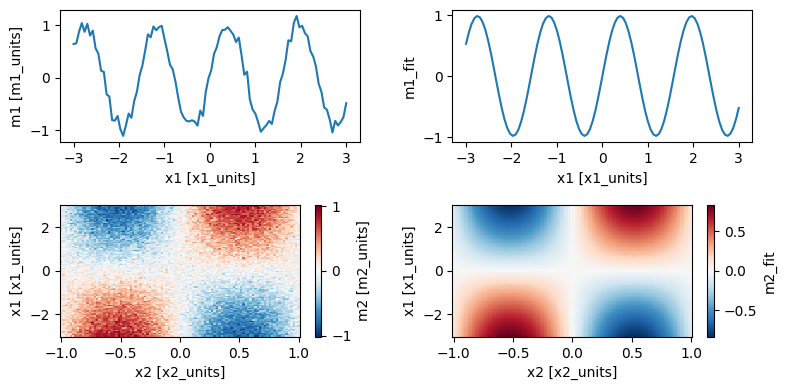

In [22]:
# Adding the fitting data to the measured data xarray
dsx['m1_fit'] = ('x1', m1_fitted)
dsx['m2_fit'] = (('x1', 'x2'), m2_fitted)

# Add the result of the fit as HDF5 attributes to the xarray (they will be stored in the HDF5 file upon conversion)
dsx.attrs = {
    'fit_params': {
        'm1_fit': {'amplitude': params_m1[0], 'freq': params_m1[0]},
    }
}

# Plotting measured data and fits
fig, axs = plt.subplots(2,2,figsize=[8,4])
dsx.m1.plot(ax=axs[0,0])
dsx.m2.plot(ax=axs[1,0])
dsx.m1_fit.plot(ax=axs[0,1])
dsx.m2_fit.plot(ax=axs[1,1])
plt.tight_layout()

# Save the plot to png image
plt.savefig('data/fit.png')

# Uploading the fit data and png

In [23]:
from pathlib import Path

# Add the xarray with the fitted data to the qdrive dataset as 'analysis' file (HDF5_NETCDF)
dsq['analysis.hdf5'] = dsx

# Add to the qdrive dataset the png picture of the fitted data
dsq['fit_image.png'] = Path('data/fit.png')


In [24]:
# inspect the final qdrive dataset
dsq

Contents of dataset :: Test ds from python

uuid :: 7401c239-02b4-4a15-8d99-afa40ac120bb
Description :: My dataset description
Scope :: test scope QH
Ranking :: 1
Data Indentifiers :: 
	set_up : Fridge B256
	sample_id : Q7-R3
Files :: 
name         filename          type                  selected version number (version_id)      Maximal version number  Starred    Hidden
-----------  ----------------  --------------------  --------------------------------------  ------------------------  ---------  --------
measurement  measurement.hdf5  FileType.HDF5_NETCDF  0 (1756658157017)                                              0  No         No
settings     settings.json     FileType.JSON         0 (1756658157035)                                              0  No         No
README       README.txt        FileType.UNKNOWN      0 (1756658157042)                                              0  No         No
analysis     analysis.hdf5     FileType.HDF5_NETCDF  0 (1756658158079)                   

<br>

You can see that the dataset contains:
 - the measurement data and the setting file
 - the analisys data and the fit image 

The dataset is automatically syncronized to the qdrive server so it will be available to any logged in user with permission to the scope where the dataset is located. 

You can view the dataset and all its files in the dataqruiser app. Note that we added some HDF5 attribute to both measurement and analysis hdf5 files, they are visible in dataQruiser app clicking on `show HDF5 metadata`
